In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from functools import lru_cache
import evaluate
from tqdm import tqdm

In [3]:
@lru_cache(maxsize=512)
def generate_clause_heading_pipeline_single(clause, summarizer, max_length=6, min_length=2, max_input_length = 512):
    """
    Generate a heading for a single clause using the summarization pipeline.
    Args:
        clause (str): A single clause text.
        summarizer (pipeline): Hugging Face summarization pipeline.
        max_length (int): Maximum length of the generated heading.
        min_length (int): Minimum length of the generated heading.
        max_input_length(int): Maximum length of the input text.
    Returns:
        str: The generated heading.
    """
    tokenized_length = len(clause.split())

    # Truncate the clause if it's too long
    if tokenized_length > max_input_length:
        clause = " ".join(clause.split()[:max_input_length])

    # Generate the summary
    try:
        summary = summarizer(clause, max_length=max_length, min_length=min_length, do_sample=False)[0]["summary_text"]
    except Exception as e:
        return f"Error generating heading: {str(e)}"

    return summary

### Sanity

In [4]:
clauses = [
    "The system shall detect and report any failure in the primary sensor within 10 milliseconds to avoid false readings.",
    "All redundant control channels must undergo cross-verification every 5 seconds to ensure functional safety and prevent system failure.",
    "Software components handling safety-critical tasks must log events and errors in compliance with ISO 26262 Part 6, Section 9."
]

In [5]:
summarizer = pipeline("summarization", model="google/pegasus-xsum")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


In [6]:
heading = generate_clause_heading_pipeline_single(clauses[0], summarizer= summarizer)
print(f"{heading}")

The purpose of this


In [7]:
from keybert import KeyBERT

In [8]:
# Function to generate keyword-based heading for a single clause
def generate_keyword_heading(clause, num_kw=5, num_kw_to_return=1, kw_model: KeyBERT = None):
    """
    Generate a keyword-based heading for a single clause.
    
    Args:
        clause (str): The clause text.
        num_keywords (int): Number of keywords to extract for the heading.
        
    Returns:
        str: A keyword-based heading.
    """
    
    keywords = kw_model.extract_keywords(clause, keyphrase_ngram_range=(1, 3), top_n=num_kw)
    
    keywords_text = ", ".join([kw[0] for kw in keywords[:num_kw_to_return]])  # Join top keywords into a heading
    return keywords_text

In [9]:
model = KeyBERT('all-MiniLM-L6-v2')
heading = generate_keyword_heading(clauses[0], num_kw=3, num_kw_to_return=1, kw_model=model)
print(f"{heading}")

failure primary sensor


### Load data

In [12]:
from pathlib import Path

In [14]:
data_dir = Path().cwd().parent.parent.joinpath('sagemaker', 'data')

In [15]:
file_path = data_dir.joinpath('parsed_docs_w_tags.csv')

In [22]:
df = pd.read_csv(file_path, index_col=0)

In [23]:
df.head()

,Document,Clause Number,Clause Heading,Clause Text,Human Heading,Tag
0,EN50128,1,Scope,NaN,Scope,u
1,EN50128,1.1,NaN,This European Standard specifies the process a...,SCOPE,s
2,EN50128,1.2,NaN,This European Standard is applicable exclusive...,SCOPE,s
3,EN50128,1.3,NaN,This European Standard is not relevant for sof...,SCOPE,s
4,EN50128,1.4,NaN,This European Standard applies to all safety r...,SCOPE,s


In [24]:
df.shape

(846, 6)

## Generate headings

In [25]:
df.dropna(subset=['Clause Text'], inplace=True)
df.shape

(716, 6)

In [26]:
df.dropna(subset=['Human Heading'], inplace=True)
df.shape

(716, 6)

### keybert

In [27]:
kw_model = KeyBERT('all-MiniLM-L6-v2')

In [28]:
tqdm.pandas()

In [29]:
df["Keybert-all-MiniLM-L6-v2"] = df["Clause Text"].progress_apply(lambda clause: generate_keyword_heading(str(clause), kw_model=kw_model))

100%|██████████| 716/716 [03:01<00:00,  3.94it/s]


In [31]:
df.head()

,Document,Clause Number,Clause Heading,Clause Text,Human Heading,Tag,Keybert-all-MiniLM-L6-v2
1,EN50128,1.1,NaN,This European Standard specifies the process a...,SCOPE,s,railway control protection
2,EN50128,1.2,NaN,This European Standard is applicable exclusive...,SCOPE,s,european standard applicable
3,EN50128,1.3,NaN,This European Standard is not relevant for sof...,SCOPE,s,safety software failures
4,EN50128,1.4,NaN,This European Standard applies to all safety r...,SCOPE,s,software used railway
5,EN50128,1.5,NaN,This European Standard also addresses the use ...,SCOPE,s,pre existing software


### pegasus

In [32]:
pegasus_summarizer = pipeline("summarization", model="google/pegasus-xsum")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


In [33]:
df["summarizer-pegasus-xsum"] = df["Clause Text"].progress_apply(lambda clause: generate_clause_heading_pipeline_single(clause, pegasus_summarizer, max_length=20, min_length=1))

100%|██████████| 716/716 [1:05:17<00:00,  5.47s/it]


In [34]:
df.head(20)

,Document,Clause Number,Clause Heading,Clause Text,Human Heading,Tag,Keybert-all-MiniLM-L6-v2,summarizer-pegasus-xsum
1,EN50128,1.1,NaN,This European Standard specifies the process a...,SCOPE,s,railway control protection,This standard has been published by the Europe...
2,EN50128,1.2,NaN,This European Standard is applicable exclusive...,SCOPE,s,european standard applicable,This Standard is intended for use by software ...
3,EN50128,1.3,NaN,This European Standard is not relevant for sof...,SCOPE,s,safety software failures,This European Standard is not relevant for sof...
4,EN50128,1.4,NaN,This European Standard applies to all safety r...,SCOPE,s,software used railway,This European Standard applies to all safety r...
5,EN50128,1.5,NaN,This European Standard also addresses the use ...,SCOPE,s,pre existing software,This European Standard sets out the requiremen...
6,EN50128,1.6,NaN,Software developed according to any version of...,SCOPE,s,standard considered compliant,This European Standard is intended for use by ...
7,EN50128,1.7,NaN,This European Standard considers that modern a...,SCOPE,s,generic software clause,This European Standard has been adopted by the...
8,EN50128,1.8,NaN,This European Standard is not intended to addr...,SCOPE,s,european standard intended,This European Standard should not be confused ...
9,EN50128,1.9,NaN,This European Standard is not intended to be r...,SCOPE,s,european standard upgrades,This European Standard covers the following:
10,EN50128,2,Normative references,The following referenced documents are indispe...,Normative references,u,railway applications specification,This document has been prepared by the Interna...


In [36]:
df.to_csv(data_dir.joinpath('new_summerries_keybert_pegasus.csv'))

### T5

In [37]:
t5_summarizer = pipeline("summarization", model="t5-small", tokenizer="t5-small")

Device set to use cpu


In [39]:
df["summarizer-t5-small"] = df["Clause Text"].progress_apply(lambda clause: generate_clause_heading_pipeline_single(clause, t5_summarizer, max_length=10, min_length=1))

100%|██████████| 716/716 [08:18<00:00,  1.44it/s]


In [40]:
df.head(20)

,Document,Clause Number,Clause Heading,Clause Text,Human Heading,Tag,Keybert-all-MiniLM-L6-v2,summarizer-pegasus-xsum,summarizer-t5-small
1,EN50128,1.1,NaN,This European Standard specifies the process a...,SCOPE,s,railway control protection,This standard has been published by the Europe...,programmable electronic systems can be impleme...
2,EN50128,1.2,NaN,This European Standard is applicable exclusive...,SCOPE,s,european standard applicable,This Standard is intended for use by software ...,this European Standard is applicable exclusive...
3,EN50128,1.3,NaN,This European Standard is not relevant for sof...,SCOPE,s,safety software failures,This European Standard is not relevant for sof...,this European Standard is not relevant for sof...
4,EN50128,1.4,NaN,This European Standard applies to all safety r...,SCOPE,s,software used railway,This European Standard applies to all safety r...,application programming comprises high level p...
5,EN50128,1.5,NaN,This European Standard also addresses the use ...,SCOPE,s,pre existing software,This European Standard sets out the requiremen...,7.3.4.7 and 6.5.4.16
6,EN50128,1.6,NaN,Software developed according to any version of...,SCOPE,s,standard considered compliant,This European Standard is intended for use by ...,software developed according to any version of...
7,EN50128,1.7,NaN,This European Standard considers that modern a...,SCOPE,s,generic software clause,This European Standard has been adopted by the...,the general Clauses 1 to 6 and
8,EN50128,1.8,NaN,This European Standard is not intended to addr...,SCOPE,s,european standard intended,This European Standard should not be confused ...,this European Standard is not intended to addr...
9,EN50128,1.9,NaN,This European Standard is not intended to be r...,SCOPE,s,european standard upgrades,This European Standard covers the following:,this European Standard is not intended to be r...
10,EN50128,2,Normative references,The following referenced documents are indispe...,Normative references,u,railway applications specification,This document has been prepared by the Interna...,"for dated references, only the edition"


In [41]:
df.to_csv(data_dir.joinpath('new_summerries_keybert_pegasus_t5.csv'))

### Evaluation

#### Genrerate embeddings

##### all-MiniLM-L6-v2

In [42]:
embeddings_model = SentenceTransformer('all-MiniLM-L6-v2')

In [43]:
# Cache function to store embeddings
@lru_cache(maxsize=100)  # Cache up to 100 entries, adjust as needed
def get_embedding(text, embeddings_model = embeddings_model, show_progress=True):
    """
    Compute and cache the embedding for a given text.
    """
    embedding = embeddings_model.encode(text, show_progress_bar=show_progress)
    return tuple(embedding)  # Tuples are hashable and compatible with lru_cache

In [44]:
df["embeddings-Heading"] = df["Human Heading"].progress_apply(lambda summary: get_embedding(str(summary), show_progress=False))

100%|██████████| 716/716 [00:02<00:00, 267.52it/s]


In [45]:
df["embeddings-Keybert-all-MiniLM-L6-v2"] = df["Keybert-all-MiniLM-L6-v2"].progress_apply(lambda summary: get_embedding(summary, show_progress=False))

100%|██████████| 716/716 [00:05<00:00, 129.46it/s]


In [46]:
df.head()

,Document,Clause Number,Clause Heading,Clause Text,Human Heading,Tag,Keybert-all-MiniLM-L6-v2,summarizer-pegasus-xsum,summarizer-t5-small,embeddings-Heading,embeddings-Keybert-all-MiniLM-L6-v2
1,EN50128,1.1,NaN,This European Standard specifies the process a...,SCOPE,s,railway control protection,This standard has been published by the Europe...,programmable electronic systems can be impleme...,"(0.009632393, 0.03896258, -0.034440175, 0.0282...","(-0.094804406, 0.012879065, 0.008214989, 0.098..."
2,EN50128,1.2,NaN,This European Standard is applicable exclusive...,SCOPE,s,european standard applicable,This Standard is intended for use by software ...,this European Standard is applicable exclusive...,"(0.009632393, 0.03896258, -0.034440175, 0.0282...","(0.0059420005, 0.023941863, -0.026089476, -0.0..."
3,EN50128,1.3,NaN,This European Standard is not relevant for sof...,SCOPE,s,safety software failures,This European Standard is not relevant for sof...,this European Standard is not relevant for sof...,"(0.009632393, 0.03896258, -0.034440175, 0.0282...","(-0.05027322, 0.017859844, -0.019936524, -0.06..."
4,EN50128,1.4,NaN,This European Standard applies to all safety r...,SCOPE,s,software used railway,This European Standard applies to all safety r...,application programming comprises high level p...,"(0.009632393, 0.03896258, -0.034440175, 0.0282...","(-0.0715207, -0.014608854, -0.028855726, 0.021..."
5,EN50128,1.5,NaN,This European Standard also addresses the use ...,SCOPE,s,pre existing software,This European Standard sets out the requiremen...,7.3.4.7 and 6.5.4.16,"(0.009632393, 0.03896258, -0.034440175, 0.0282...","(-0.079993464, -0.036486488, 0.023212254, -0.0..."


In [47]:
df["embeddings-summarizer-pegasus-xsum"] = df["summarizer-pegasus-xsum"].progress_apply(lambda summary: get_embedding(summary, show_progress=False))

100%|██████████| 716/716 [00:08<00:00, 86.58it/s] 


In [48]:
df["embeddings-summarizer-t5-small"] = df["summarizer-t5-small"].progress_apply(lambda summary: get_embedding(summary, show_progress=False))


100%|██████████| 716/716 [00:07<00:00, 93.77it/s] 


### Evaluation

#### ROUGE

In [49]:
import evaluate

In [50]:
rouge = evaluate.load('rouge')

In [51]:
def compute_rouge_row(reference, prediction, rouge_type="rougeL"):
    """
    Compute ROUGE scores for a single reference and prediction pair.
    
    Args:
        reference (str): The reference heading (gold standard).
        prediction (str): The generated summary (KeyBERT summary).
        rouge_type (str): The type of ROUGE score to compute ("rouge1", "rouge2", "rougeL").

    Returns:
        float: ROUGE F1 score of the specified type.
    """
    # Handle missing values
    reference = reference if pd.notna(reference) else ""
    prediction = prediction if pd.notna(prediction) else ""

    # Compute ROUGE score
    score = rouge.compute(predictions=[prediction], references=[reference])
    return score[rouge_type]

In [55]:
df["rouge-1-Keybert-all-MiniLM-L6-v2"] = df.progress_apply(lambda row: compute_rouge_row(row["Human Heading"], row["Keybert-all-MiniLM-L6-v2"], 'rouge1'), axis=1)

100%|██████████| 716/716 [01:27<00:00,  8.16it/s]


In [56]:
df["rouge-L-Keybert-all-MiniLM-L6-v2"] = df.progress_apply(lambda row: compute_rouge_row(row["Human Heading"], row["Keybert-all-MiniLM-L6-v2"], 'rougeL'), axis=1)

100%|██████████| 716/716 [01:15<00:00,  9.42it/s]


In [57]:
df["rouge-1-summarizer-pegasus-xsum"] = df.progress_apply(lambda row: compute_rouge_row(row["Human Heading"], row["summarizer-pegasus-xsum"], 'rouge1'), axis=1)

100%|██████████| 716/716 [02:37<00:00,  4.56it/s]


In [58]:
df["rouge-L-summarizer-pegasus-xsum"] = df.progress_apply(lambda row: compute_rouge_row(row["Human Heading"], row["summarizer-pegasus-xsum"], 'rougeL'), axis=1)

100%|██████████| 716/716 [02:45<00:00,  4.33it/s]


In [60]:
df["rouge-1-summarizer-t5-small"] = df.progress_apply(lambda row: compute_rouge_row(row["Human Heading"], row["summarizer-t5-small"], 'rouge1'), axis=1)

100%|██████████| 716/716 [00:52<00:00, 13.60it/s]


In [80]:
df["rouge-L-summarizer-t5-small"] = df.progress_apply(lambda row: compute_rouge_row(row["Human Heading"], row["summarizer-t5-small"], 'rougeL'), axis=1)

100%|██████████| 716/716 [00:51<00:00, 13.80it/s]


In [61]:
df.head()

,Document,Clause Number,Clause Heading,Clause Text,Human Heading,Tag,Keybert-all-MiniLM-L6-v2,summarizer-pegasus-xsum,summarizer-t5-small,embeddings-Heading,embeddings-Keybert-all-MiniLM-L6-v2,embeddings-summarizer-pegasus-xsum,embeddings-summarizer-t5-small,rouge-1-Keybert-all-MiniLM-L6-v2,rouge-L-Keybert-all-MiniLM-L6-v2,rouge-1-summarizer-pegasus-xsum,rouge-L-summarizer-pegasus-xsum,rouge-1-summarizer-t5-small
1,EN50128,1.1,NaN,This European Standard specifies the process a...,SCOPE,s,railway control protection,This standard has been published by the Europe...,programmable electronic systems can be impleme...,"(0.009632393, 0.03896258, -0.034440175, 0.0282...","(-0.094804406, 0.012879065, 0.008214989, 0.098...","(0.012583623, 0.04773652, -0.090783685, 0.0182...","(-0.06986263, 0.047352523, -0.095013924, -0.06...",0.0,0.0,0.0,0.0,0.0
2,EN50128,1.2,NaN,This European Standard is applicable exclusive...,SCOPE,s,european standard applicable,This Standard is intended for use by software ...,this European Standard is applicable exclusive...,"(0.009632393, 0.03896258, -0.034440175, 0.0282...","(0.0059420005, 0.023941863, -0.026089476, -0.0...","(-0.05959746, 0.009036754, -0.08797326, -0.052...","(-0.013446538, 0.015289357, -0.054077435, -0.1...",0.0,0.0,0.0,0.0,0.0
3,EN50128,1.3,NaN,This European Standard is not relevant for sof...,SCOPE,s,safety software failures,This European Standard is not relevant for sof...,this European Standard is not relevant for sof...,"(0.009632393, 0.03896258, -0.034440175, 0.0282...","(-0.05027322, 0.017859844, -0.019936524, -0.06...","(0.019806987, 0.046919122, -0.048790477, -0.09...","(0.0054376503, 0.026909212, -0.048973463, -0.1...",0.0,0.0,0.0,0.0,0.0
4,EN50128,1.4,NaN,This European Standard applies to all safety r...,SCOPE,s,software used railway,This European Standard applies to all safety r...,application programming comprises high level p...,"(0.009632393, 0.03896258, -0.034440175, 0.0282...","(-0.0715207, -0.014608854, -0.028855726, 0.021...","(-0.038539495, -0.019001987, -0.056187857, -0....","(-0.03427112, 0.007936827, -0.0047192476, -0.0...",0.0,0.0,0.0,0.0,0.0
5,EN50128,1.5,NaN,This European Standard also addresses the use ...,SCOPE,s,pre existing software,This European Standard sets out the requiremen...,7.3.4.7 and 6.5.4.16,"(0.009632393, 0.03896258, -0.034440175, 0.0282...","(-0.079993464, -0.036486488, 0.023212254, -0.0...","(-0.015493689, 0.037855, -0.06615921, -0.06667...","(-0.018297635, -0.01638731, 0.021949157, -0.02...",0.0,0.0,0.0,0.0,0.0


#### semantic

In [62]:
import numpy as np

In [63]:
def compute_row_similarity(embedding1, embedding2):
    """
    Compute the cosine similarity between two embeddings with validation.
    
    Args:
        embedding1 (array-like or None): First embedding.
        embedding2 (array-like or None): Second embedding.
        
    Returns:
        float: Cosine similarity score if embeddings are valid, otherwise NaN.
    """
    # Check for None or NaN embeddings
    if pd.isna(embedding1) or pd.isna(embedding2):
        return np.nan  # Return NaN if any embedding is missing
    
    # Convert tuples/lists to NumPy arrays for cosine similarity
    if isinstance(embedding1, (tuple, list)):
        embedding1 = np.array(embedding1)
    if isinstance(embedding2, (tuple, list)):
        embedding2 = np.array(embedding2)
    
    # Check that embeddings have the same length
    if embedding1.shape != embedding2.shape:
        return np.nan  # Return NaN if embeddings are not of the same shape
    
    # Compute and return cosine similarity
    return cosine_similarity([embedding1], [embedding2])[0][0]

In [64]:
df["cosine-Keybert-all-MiniLM-L6-v2"] = df.progress_apply(lambda row: compute_row_similarity(row["embeddings-Heading"], row["embeddings-Keybert-all-MiniLM-L6-v2"]),axis=1)

100%|██████████| 716/716 [00:00<00:00, 4798.02it/s]


In [65]:
df["cosine-summarizer-pegasus-xsum"] = df.progress_apply(lambda row: compute_row_similarity(row["embeddings-Heading"], row["embeddings-summarizer-pegasus-xsum"]),axis=1)

100%|██████████| 716/716 [00:00<00:00, 4771.65it/s]


In [66]:
df["cosine-summarizer-t5-small"] = df.progress_apply(lambda row: compute_row_similarity(row["embeddings-Heading"], row["embeddings-summarizer-t5-small"]),axis=1)

100%|██████████| 716/716 [00:00<00:00, 4885.84it/s]


In [79]:
df.head()

,Document,Clause Number,Clause Heading,Clause Text,Human Heading,Tag,Keybert-all-MiniLM-L6-v2,summarizer-pegasus-xsum,summarizer-t5-small,embeddings-Heading,...,embeddings-summarizer-pegasus-xsum,embeddings-summarizer-t5-small,rouge-1-Keybert-all-MiniLM-L6-v2,rouge-L-Keybert-all-MiniLM-L6-v2,rouge-1-summarizer-pegasus-xsum,rouge-L-summarizer-pegasus-xsum,rouge-1-summarizer-t5-small,cosine-Keybert-all-MiniLM-L6-v2,cosine-summarizer-pegasus-xsum,cosine-summarizer-t5-small
1,EN50128,1.1,NaN,This European Standard specifies the process a...,SCOPE,s,railway control protection,This standard has been published by the Europe...,programmable electronic systems can be impleme...,"(0.009632393, 0.03896258, -0.034440175, 0.0282...",...,"(0.012583623, 0.04773652, -0.090783685, 0.0182...","(-0.06986263, 0.047352523, -0.095013924, -0.06...",0.0,0.0,0.0,0.0,0.0,0.096626,0.149391,0.083334
2,EN50128,1.2,NaN,This European Standard is applicable exclusive...,SCOPE,s,european standard applicable,This Standard is intended for use by software ...,this European Standard is applicable exclusive...,"(0.009632393, 0.03896258, -0.034440175, 0.0282...",...,"(-0.05959746, 0.009036754, -0.08797326, -0.052...","(-0.013446538, 0.015289357, -0.054077435, -0.1...",0.0,0.0,0.0,0.0,0.0,0.145781,0.156084,0.124848
3,EN50128,1.3,NaN,This European Standard is not relevant for sof...,SCOPE,s,safety software failures,This European Standard is not relevant for sof...,this European Standard is not relevant for sof...,"(0.009632393, 0.03896258, -0.034440175, 0.0282...",...,"(0.019806987, 0.046919122, -0.048790477, -0.09...","(0.0054376503, 0.026909212, -0.048973463, -0.1...",0.0,0.0,0.0,0.0,0.0,0.109187,0.123902,0.149423
4,EN50128,1.4,NaN,This European Standard applies to all safety r...,SCOPE,s,software used railway,This European Standard applies to all safety r...,application programming comprises high level p...,"(0.009632393, 0.03896258, -0.034440175, 0.0282...",...,"(-0.038539495, -0.019001987, -0.056187857, -0....","(-0.03427112, 0.007936827, -0.0047192476, -0.0...",0.0,0.0,0.0,0.0,0.0,0.106486,0.047205,0.211130
5,EN50128,1.5,NaN,This European Standard also addresses the use ...,SCOPE,s,pre existing software,This European Standard sets out the requiremen...,7.3.4.7 and 6.5.4.16,"(0.009632393, 0.03896258, -0.034440175, 0.0282...",...,"(-0.015493689, 0.037855, -0.06615921, -0.06667...","(-0.018297635, -0.01638731, 0.021949157, -0.02...",0.0,0.0,0.0,0.0,0.0,0.146125,0.213242,0.134241


### Visualizations

In [68]:
import matplotlib.pyplot as plt

In [69]:
plt.style.use("ggplot")

#### 1. Bar Plot: Mean Scores by Method

In [76]:
def filter_empty_rows(df):
    """
    Remove rows where Heading or Clause columns contain NaN or empty strings.
    """
    return df[(df["Human Heading"].notna()) & (df["Clause Text"].notna()) & (df["Human Heading"].str.strip() != "") & (df["Clause Text"].str.strip() != "")]


In [77]:
def plot_mean_scores(df):
    """
    Plot the mean ROUGE-1, ROUGE-L, and Cosine Similarity scores for each method.
    """
    # Filter rows
    df = filter_empty_rows(df)

    # Prepare data for the plot
    mean_scores = pd.DataFrame({
        "Method": ["KeyBERT", "T5-small", "Pegasus-xsum"],
        "ROUGE-1": [
            df["rouge-1-Keybert-all-MiniLM-L6-v2"].mean(),
            df["rouge-1-summarizer-t5-small"].mean(),
            df["rouge-1-summarizer-pegasus-xsum"].mean()
        ],
        "ROUGE-L": [
            df["rouge-L-Keybert-all-MiniLM-L6-v2"].mean(),
            df["rouge-L-summarizer-t5-small"].mean(),
            df["rouge-L-summarizer-pegasus-xsum"].mean()
        ],
        "Cosine Similarity": [
            df["cosine-Keybert-all-MiniLM-L6-v2"].mean(),
            df["cosine-summarizer-t5-small"].mean(),
            df["cosine-summarizer-pegasus-xsum"].mean()
        ]
    })

    # Plot bar chart
    mean_scores.plot(kind='bar', x='Method', y=['ROUGE-1', 'ROUGE-L', 'Cosine Similarity'], figsize=(10, 6))
    plt.title("Mean ROUGE and Cosine Similarity Scores by Method")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.legend(loc="upper left")
    plt.show()


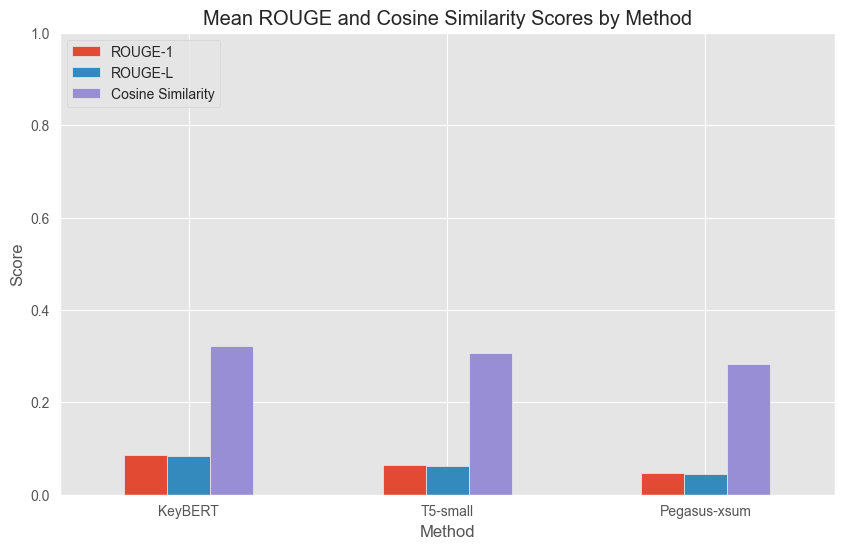

In [81]:
plot_mean_scores(df=df)

In [82]:
mean_scores = pd.DataFrame({
        "Method": ["KeyBERT", "T5-small", "Pegasus-xsum"],
        "ROUGE-1": [
            df["rouge-1-Keybert-all-MiniLM-L6-v2"].mean(),
            df["rouge-1-summarizer-t5-small"].mean(),
            df["rouge-1-summarizer-pegasus-xsum"].mean()
        ],
        "ROUGE-L": [
            df["rouge-L-Keybert-all-MiniLM-L6-v2"].mean(),
            df["rouge-L-summarizer-t5-small"].mean(),
            df["rouge-L-summarizer-pegasus-xsum"].mean()
        ],
        "Cosine Similarity": [
            df["cosine-Keybert-all-MiniLM-L6-v2"].mean(),
            df["cosine-summarizer-t5-small"].mean(),
            df["cosine-summarizer-pegasus-xsum"].mean()
        ]
    })

In [83]:
print("\nSummarization Results:\n")
print(mean_scores.to_string(index=False, float_format="{:.4f}".format))


Summarization Results:

      Method  ROUGE-1  ROUGE-L  Cosine Similarity
     KeyBERT   0.0860   0.0843             0.3224
    T5-small   0.0650   0.0623             0.3068
Pegasus-xsum   0.0474   0.0452             0.2828


#### Box Plot: Score Distributions

In [113]:
def plot_score_distributions(df):
    """
    Plot box plots for score distributions for each method.
    """
    # Filter rows
    df = filter_empty_rows(df)

    metrics = {
        "ROUGE-1": ["rouge-1-Keybert-all-MiniLM-L6-v2", "rouge-1-summarizer-t5-small", "rouge-1-summarizer-pegasus-xsum"],
        "ROUGE-L": ["rouge-L-Keybert-all-MiniLM-L6-v2", "rouge-L-summarizer-t5-small", "rouge-L-summarizer-pegasus-xsum"],
        "Cosine Similarity": ["cosine-Keybert-all-MiniLM-L6-v2", "cosine-summarizer-t5-small", "cosine-summarizer-pegasus-xsum"]
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for idx, (metric_name, columns) in enumerate(metrics.items()):
        melted_df = pd.melt(df, value_vars=columns, var_name="Method", value_name=metric_name)
        melted_df["Method"] = melted_df["Method"].map({
            "rouge-1-Keybert-all-MiniLM-L6-v2": "KeyBERT",
            "rouge-1-summarizer-t5-small": "T5-small",
            "rouge-1-summarizer-pegasus-xsum": "Pegasus-xsum",
            "rouge-L-Keybert-all-MiniLM-L6-v2": "KeyBERT",
            "rouge-L-summarizer-t5-small": "T5-small",
            "rouge-L-summarizer-pegasus-xsum": "Pegasus-xsum",
            "cosine-Keybert-all-MiniLM-L6-v2": "KeyBERT",
            "cosine-summarizer-t5-small": "T5-small",
            "cosine-summarizer-pegasus-xsum": "Pegasus-xsum"
        })

        melted_df.boxplot(column=metric_name, by="Method", ax=axes[idx], grid=False)
        axes[idx].set_title(f"{metric_name} Distribution")
        axes[idx].set_xlabel("Method")
        axes[idx].set_ylabel("Score")
        axes[idx].set_ylim(0, 1)

    plt.suptitle("Score Distributions by Method")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

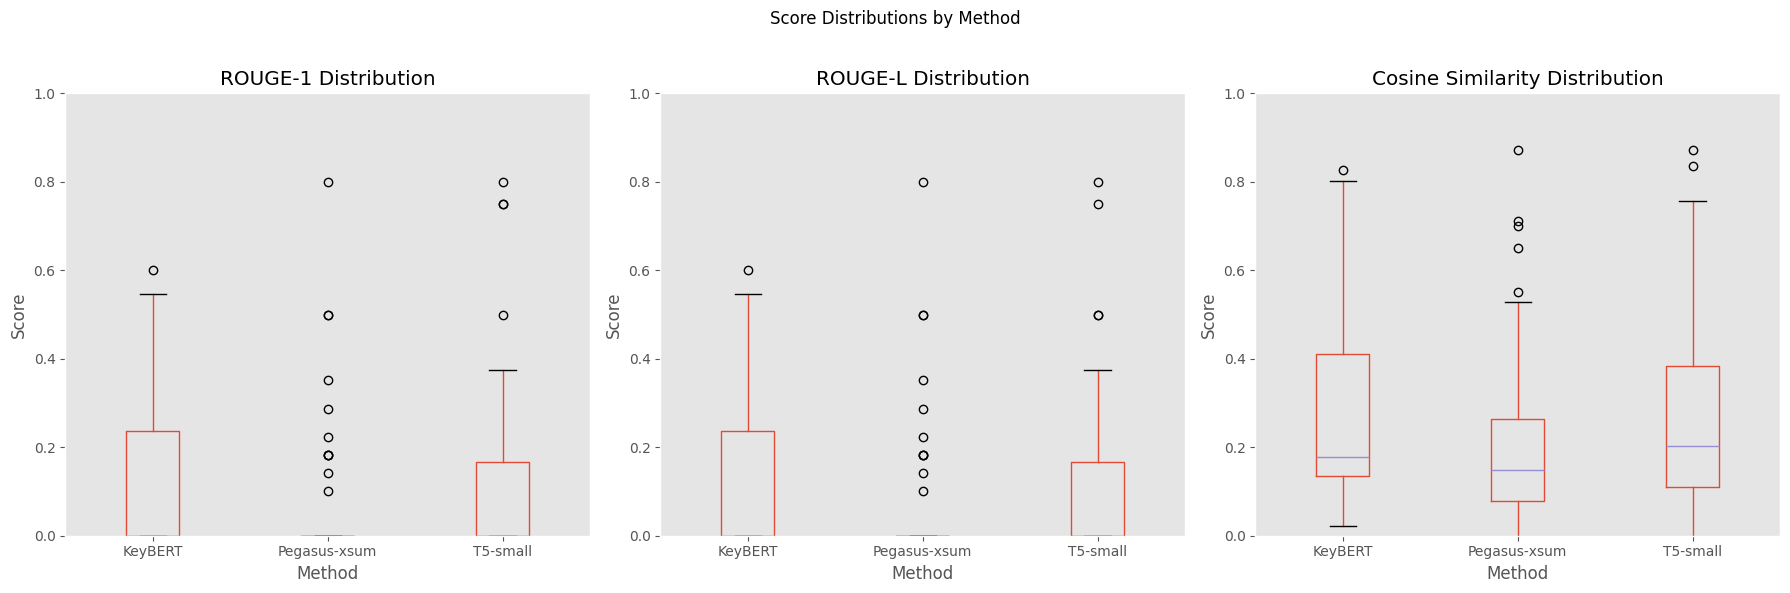

In [114]:
plot_score_distributions(df=df)

#### Scatter Plot: ROUGE vs Cosine Similarity

In [116]:
def plot_scatter_scores(df):
    """
    Scatter plot showing the relationship between ROUGE-L and Cosine Similarity scores for each method.
    """
    # Filter rows
    df = filter_empty_rows(df)

    plt.figure(figsize=(10, 6))
    colors = {'KeyBERT': 'red', 'T5-small': 'blue', 'Pegasus-xsum': 'green'}

    methods = {
        "KeyBERT": ("rouge-L-Keybert-all-MiniLM-L6-v2", "cosine-Keybert-all-MiniLM-L6-v2"),
        "T5-small": ("rouge-L-summarizer-t5-small", "cosine-summarizer-t5-small"),
        "Pegasus-xsum": ("rouge-L-summarizer-pegasus-xsum", "cosine-summarizer-pegasus-xsum")
    }

    for method, (rouge_col, cosine_col) in methods.items():
        plt.scatter(df[rouge_col], df[cosine_col], label=method, color=colors[method], alpha=0.6, s=100)

    plt.title("ROUGE-L vs Cosine Similarity by Method")
    plt.xlabel("ROUGE-L Score")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.grid(True)
    plt.show()


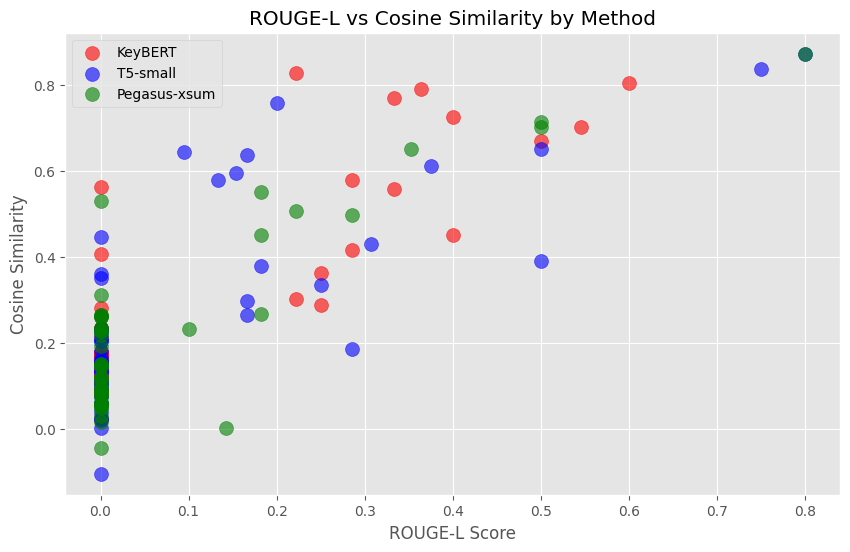

In [117]:
plot_scatter_scores(df)